# Importing the 5 datasets (2 IPL, 3 International)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading datasets
ipl_ball_by_ball = pd.read_csv('IPL_Ball_by_Ball_2008_2022.csv')
ipl_matches = pd.read_csv('IPL_Matches_2008_2022.csv')
espncricinfo_batsmen = pd.read_excel('espn_t20_batsmen.xlsx')
espncricinfo_bowlers = pd.read_excel('espn_t20_bowlers.xlsx')
espncricinfo_fielders = pd.read_excel('espn_t20_fielders.xlsx')

# Merging ipl_ball_by_ball with ipl_matches to get the Date and Venue
ipl_ball_by_ball = pd.merge(ipl_ball_by_ball, ipl_matches[['ID', 'Date', 'Venue']], left_on='ID', right_on='ID', how='left')
ipl_ball_by_ball['Date'] = pd.to_datetime(ipl_ball_by_ball['Date'])

# Traditional Attributes for IPL Data

### Traditional Batting and Bowling Attributes
Following the methods described by Kalpdrum Passi and Niravkumar Pandey (2018), traditional attributes such as the number of innings, runs, balls faced, and wickets are calculated. These metrics form the basis for assessing player performance:

- **Batting Attributes:** Includes innings, runs, strike rate, and average. These indicate the player's ability to score and their efficiency.
- **Bowling Attributes:** Comprises innings bowled, overs, runs conceded, and wickets taken. These metrics gauge the bowler's ability to restrict runs and take wickets.

These traditional statistics are essential for building the foundational understanding of each player's game performance.

In [2]:
# Calculating traditional batting attributes
ipl_batting_stats = ipl_ball_by_ball.groupby('batter').agg({
    'ID': 'count',               # Innings
    'ballnumber': 'count',       # Balls Faced
    'batsman_run': 'sum',        # Runs
    'isWicketDelivery': 'sum'    # Dismissals
}).reset_index()

ipl_batting_stats.columns = ['Player', 'Innings', 'Balls Faced', 'Runs', 'Dismissals']
ipl_batting_stats['Batting Average'] = ipl_batting_stats['Runs'] / ipl_batting_stats['Dismissals']
ipl_batting_stats['Strike Rate'] = (ipl_batting_stats['Runs'] / ipl_batting_stats['Balls Faced']) * 100

# Calculating runs scored per match per player
player_runs_per_match = ipl_ball_by_ball.groupby(['ID', 'batter'])['batsman_run'].sum().reset_index()

# Calculating centuries and fifties
ipl_batting_stats['Centuries'] = player_runs_per_match[player_runs_per_match['batsman_run'] >= 100].groupby('batter').size().reindex(ipl_batting_stats['Player'], fill_value=0).reset_index(drop=True)
ipl_batting_stats['Fifties'] = player_runs_per_match[(player_runs_per_match['batsman_run'] >= 50) & (player_runs_per_match['batsman_run'] < 100)].groupby('batter').size().reindex(ipl_batting_stats['Player'], fill_value=0).reset_index(drop=True)

# Calculating zeros
zeroes_df = ipl_ball_by_ball[(ipl_ball_by_ball['batsman_run'] == 0) & (ipl_ball_by_ball['isWicketDelivery'] == 1)].groupby('batter').size().reset_index(name='Zeros')
ipl_batting_stats = ipl_batting_stats.merge(zeroes_df, how='left', left_on='Player', right_on='batter').drop(columns=['batter'])
ipl_batting_stats['Zeros'] = ipl_batting_stats['Zeros'].fillna(0)

# Calculating highest score
highest_score_df = player_runs_per_match.groupby('batter')['batsman_run'].max().reset_index(name='Highest Score')
ipl_batting_stats = ipl_batting_stats.merge(highest_score_df, how='left', left_on='Player', right_on='batter').drop(columns=['batter'])

In [3]:
ipl_batting_stats

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score
0,A Ashish Reddy,196,196,280,15,18.666667,142.857143,0,0,14.0,36
1,A Badoni,139,139,161,9,17.888889,115.827338,0,1,9.0,54
2,A Chandila,7,7,4,1,4.000000,57.142857,0,0,1.0,4
3,A Chopra,75,75,53,5,10.600000,70.666667,0,0,5.0,24
4,A Choudhary,20,20,25,2,12.500000,125.000000,0,0,2.0,15
...,...,...,...,...,...,...,...,...,...,...,...
600,Yash Dayal,1,1,0,1,0.000000,0.000000,0,0,1.0,0
601,Yashpal Singh,67,67,47,4,11.750000,70.149254,0,0,4.0,20
602,Younis Khan,7,7,3,1,3.000000,42.857143,0,0,1.0,3
603,Yuvraj Singh,2207,2207,2754,109,25.266055,124.784776,0,13,108.0,83


In [4]:
# Calculating traditional bowling attributes
ipl_bowling_stats = ipl_ball_by_ball.groupby('bowler').agg({
    'ID': 'nunique',             # Innings
    'ballnumber': 'count',       # Balls Bowled
    'batsman_run': 'sum',        # Runs Conceded
    'isWicketDelivery': 'sum'    # Wickets
}).reset_index()

ipl_bowling_stats.columns = ['Player', 'Innings', 'Balls Bowled', 'Runs Conceded', 'Wickets']
ipl_bowling_stats['Overs'] = ipl_bowling_stats['Balls Bowled'] // 6 + (ipl_bowling_stats['Balls Bowled'] % 6) / 10
ipl_bowling_stats['Bowling Average'] = ipl_bowling_stats['Runs Conceded'] / ipl_bowling_stats['Wickets']
ipl_bowling_stats['Bowling Strike Rate'] = ipl_bowling_stats['Balls Bowled'] / ipl_bowling_stats['Wickets']

# Calculating Five Wicket Hauls
bowler_wickets_per_innings = ipl_ball_by_ball.groupby(['ID', 'bowler'])['isWicketDelivery'].sum().reset_index()
five_wicket_hauls = bowler_wickets_per_innings[bowler_wickets_per_innings['isWicketDelivery'] >= 5].groupby('bowler').size().reset_index(name='Five Wicket Haul')
ipl_bowling_stats = ipl_bowling_stats.merge(five_wicket_hauls, how='left', left_on='Player', right_on='bowler').drop(columns=['bowler'])
ipl_bowling_stats['Five Wicket Haul'] = ipl_bowling_stats['Five Wicket Haul'].fillna(0)

In [5]:
ipl_bowling_stats

,Player,Innings,Balls Bowled,Runs Conceded,Wickets,Overs,Bowling Average,Bowling Strike Rate,Five Wicket Haul
0,A Ashish Reddy,20,270,386,19,45.0,20.315789,14.210526,0.0
1,A Badoni,2,12,11,2,2.0,5.500000,6.000000,0.0
2,A Chandila,12,234,242,11,39.0,22.000000,21.272727,0.0
3,A Choudhary,5,108,137,5,18.0,27.400000,21.600000,0.0
4,A Dananjaya,1,25,46,0,4.1,inf,inf,0.0
...,...,...,...,...,...,...,...,...,...
467,YK Pathan,82,1184,1372,46,197.2,29.826087,25.739130,0.0
468,YS Chahal,130,2940,3524,172,490.0,20.488372,17.093023,1.0
469,Yash Dayal,9,205,283,13,34.1,21.769231,15.769231,0.0
470,Yuvraj Singh,73,882,1064,39,147.0,27.282051,22.615385,0.0


In [6]:
# Calculating traditional fielding attributes
catches = ipl_ball_by_ball[ipl_ball_by_ball['kind'] == 'caught'].groupby('fielders_involved').size().reset_index(name='Catches')
stumpings = ipl_ball_by_ball[ipl_ball_by_ball['kind'] == 'stumped'].groupby('fielders_involved').size().reset_index(name='Stumpings')
run_outs = ipl_ball_by_ball[ipl_ball_by_ball['kind'] == 'run out'].groupby('fielders_involved').size().reset_index(name='Run Outs')

# Merging these into the main fielding stats dataframe
ipl_fielding_stats = catches.merge(stumpings, on='fielders_involved', how='outer').merge(run_outs, on='fielders_involved', how='outer')
ipl_fielding_stats.rename(columns={'fielders_involved': 'Player'}, inplace=True)
ipl_fielding_stats.fillna(0, inplace=True)
ipl_fielding_stats['Fielding Innings'] = ipl_fielding_stats[['Catches', 'Stumpings', 'Run Outs']].sum(axis=1)

In [7]:
ipl_fielding_stats

,Player,Catches,Stumpings,Run Outs,Fielding Innings
0,A Ashish Reddy,8.0,0.0,2.0,10.0
1,A Badoni,8.0,0.0,1.0,9.0
2,A Chandila,2.0,0.0,0.0,2.0
3,A Chopra,2.0,0.0,1.0,3.0
4,A Flintoff,3.0,0.0,0.0,3.0
...,...,...,...,...,...
530,HE van der Dussen,0.0,0.0,1.0,1.0
531,Mashrafe Mortaza,0.0,0.0,1.0,1.0
532,Ramandeep Singh,0.0,0.0,1.0,1.0
533,Umar Gul,0.0,0.0,1.0,1.0


# Derived Attributes for IPL Data

### Overview
Derived attributes such as Form and Consistency are calculated to provide a deeper understanding of a player's recent performance and overall reliability over their career. These metrics are weighted averages of traditional cricket statistics, designed to predict future performance based on historical data, as described by Passi and Pandey (2018).

### Form Calculation
The Form attribute reflects a player's recent performance over the last year:
- **Batting Form:** Calculated using the formula:
$$
\text{Form} = 0.4262 \cdot \text{Average} + 0.2566 \cdot \text{No. of Innings} + 0.1510 \cdot \text{Strike Rate} + 0.0787 \cdot \text{Centuries} + 0.0556 \cdot \text{Fifties} - 0.0328 \cdot \text{Zeros}
$$
- **Bowling Form:** Calculated using the formula:
$$
\text{Form} = 0.3269 \cdot \text{Overs} + 0.2846 \cdot \text{Innings} + 0.1877 \cdot \text{Strike Rate} + 0.1210 \cdot \text{Average} + 0.0798 \cdot \text{Five Wicket Haul}
$$

### Consistency Calculation
Consistency measures a player's reliability and performance throughout their career:
- **Batting Consistency:** Calculated using the formula:
$$
\text{Consistency} = 0.4262 \cdot \text{Average} + 0.2566 \cdot \text{Innings} + 0.1510 \cdot \text{Strike Rate} + 0.0787 \cdot \text{Centuries} + 0.0556 \cdot \text{Fifties} - 0.0328 \cdot \text{Zeros}
$$
- **Bowling Consistency:** Calculated using the formula:
$$
\text{Consistency} = 0.4174 \cdot \text{Overs} + 0.2634 \cdot \text{Innings} + 0.1602 \cdot \text{Strike Rate} + 0.0975 \cdot \text{Average} + 0.0615 \cdot \text{Five Wicket Haul}
$$

### Importance of Derived Attributes
These derived attributes are crucial for selecting players who are not only skilled but also in top form and consistent. They are essential for team management and coaches for making informed decisions in player selection and match strategy.

In [8]:
def calculate_batting_consistency(row):
    return (
        0.4262 * row['Batting Average'] +
        0.2566 * row['Innings'] +
        0.1510 * row['Strike Rate'] +
        0.0787 * row['Centuries'] +
        0.0556 * row['Fifties'] -
        0.0328 * row['Zeros']
    )

def calculate_batting_form(player, current_date):
    recent_matches = ipl_ball_by_ball[(ipl_ball_by_ball['batter'] == player) & (ipl_ball_by_ball['Date'] >= (current_date - pd.DateOffset(years=1)))]
    if recent_matches.empty:
        return 0
    recent_stats = recent_matches.groupby('batter').agg({
        'ID': 'count',
        'ballnumber': 'count',
        'batsman_run': 'sum',
        'isWicketDelivery': 'sum'
    }).reset_index()
    recent_stats.columns = ['Player', 'Innings', 'Balls Faced', 'Runs', 'Dismissals']
    recent_stats['Batting Average'] = recent_stats['Runs'] / recent_stats['Dismissals']
    recent_stats['Strike Rate'] = (recent_stats['Runs'] / recent_stats['Balls Faced']) * 100
    recent_stats['Centuries'] = recent_matches.groupby('batter')['batsman_run'].apply(lambda x: (x >= 100).sum()).reset_index(drop=True).iloc[0] if not recent_matches.groupby('batter')['batsman_run'].apply(lambda x: (x >= 100).sum()).empty else 0
    recent_stats['Fifties'] = recent_matches.groupby('batter')['batsman_run'].apply(lambda x: ((x >= 50) & (x < 100)).sum()).reset_index(drop=True).iloc[0] if not recent_matches.groupby('batter')['batsman_run'].apply(lambda x: ((x >= 50) & (x < 100)).sum()).empty else 0
    recent_stats['Zeros'] = recent_matches[(recent_matches['batsman_run'] == 0) & (recent_matches['isWicketDelivery'] == 1)].groupby('batter').size().reset_index(drop=True).iloc[0] if not recent_matches[(recent_matches['batsman_run'] == 0) & (recent_matches['isWicketDelivery'] == 1)].groupby('batter').size().empty else 0
    return calculate_batting_consistency(recent_stats.iloc[0])

# Calculating derived attributes for batting
current_date = pd.to_datetime('2022-05-29')
ipl_batting_stats['Consistency'] = ipl_batting_stats.apply(calculate_batting_consistency, axis=1)
ipl_batting_stats['Form'] = ipl_batting_stats['Player'].apply(lambda player: calculate_batting_form(player, current_date))

In [9]:
ipl_batting_stats

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score,Consistency,Form
0,A Ashish Reddy,196,196,280,15,18.666667,142.857143,0,0,14.0,36,79.361562,0.000000
1,A Badoni,139,139,161,9,17.888889,115.827338,0,1,9.0,54,60.541973,60.486373
2,A Chandila,7,7,4,1,4.000000,57.142857,0,0,1.0,4,12.096771,0.000000
3,A Chopra,75,75,53,5,10.600000,70.666667,0,0,5.0,24,34.269387,0.000000
4,A Choudhary,20,20,25,2,12.500000,125.000000,0,0,2.0,15,29.268900,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Yash Dayal,1,1,0,1,0.000000,0.000000,0,0,1.0,0,0.223800,0.223800
601,Yashpal Singh,67,67,47,4,11.750000,70.149254,0,0,4.0,20,32.661387,0.000000
602,Younis Khan,7,7,3,1,3.000000,42.857143,0,0,1.0,3,9.513429,0.000000
603,Yuvraj Singh,2207,2207,2754,109,25.266055,124.784776,0,13,108.0,83,593.107494,0.000000


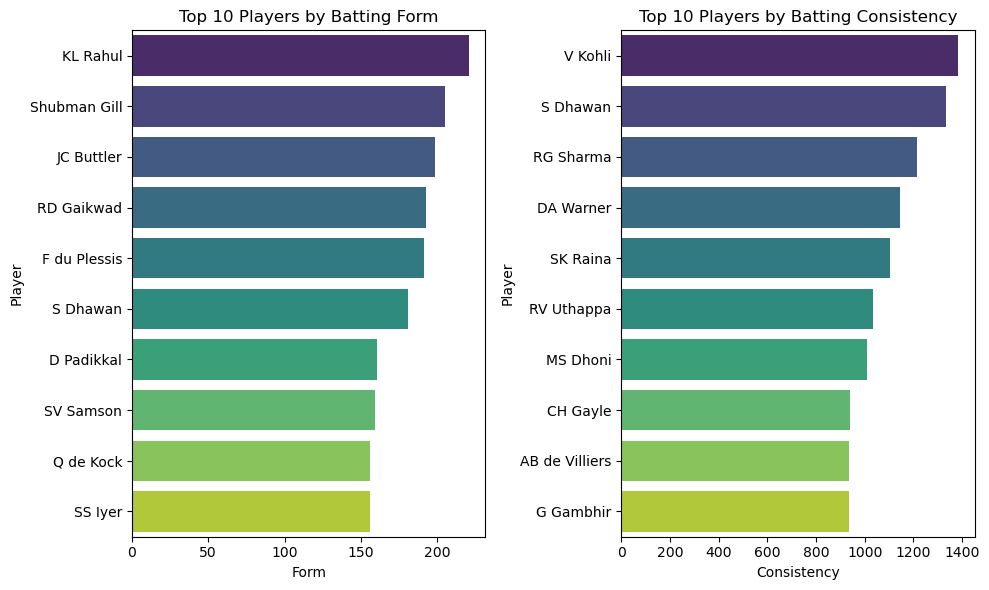

In [68]:
# Plotting Batting Form and Consistency
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Form', y='Player', data=ipl_batting_stats.sort_values(by='Form', ascending=False).head(10), palette='viridis')
plt.title('Top 10 Players by Batting Form')

plt.subplot(1, 2, 2)
sns.barplot(x='Consistency', y='Player', data=ipl_batting_stats.sort_values(by='Consistency', ascending=False).head(10), palette='viridis')
plt.title('Top 10 Players by Batting Consistency')
plt.tight_layout()
plt.show()

In [11]:
def calculate_bowling_consistency(row):
    return (
        0.4174 * row['Overs'] +
        0.2634 * row['Innings'] +
        0.1602 * row['Bowling Strike Rate'] +
        0.0975 * row['Bowling Average'] +
        0.0615 * row['Five Wicket Haul']
    )

def calculate_bowling_form(player, current_date):
    recent_matches = ipl_ball_by_ball[
        (ipl_ball_by_ball['bowler'] == player) & 
        (ipl_ball_by_ball['Date'] >= (current_date - pd.DateOffset(years=1)))
    ]
    
    if recent_matches.empty:
        return 0  # Return zero or some default scalar value if no recent matches
    
    recent_stats = recent_matches.groupby('bowler').agg({
        'ID': 'count',
        'ballnumber': 'count',
        'batsman_run': 'sum',
        'isWicketDelivery': 'sum'
    }).reset_index()
    
    recent_stats.columns = ['Player', 'Innings', 'Balls Bowled', 'Runs Conceded', 'Wickets']
    recent_stats['Overs'] = recent_stats['Balls Bowled'] // 6 + (recent_stats['Balls Bowled'] % 6) / 10
    recent_stats['Bowling Average'] = recent_stats['Runs Conceded'] / recent_stats['Wickets'] if recent_stats['Wickets'].iloc[0] != 0 else 0
    recent_stats['Bowling Strike Rate'] = recent_stats['Balls Bowled'] / recent_stats['Wickets'] if recent_stats['Wickets'].iloc[0] != 0 else 0
    
    five_wicket_hauls = recent_matches[recent_matches['isWicketDelivery'] >= 4].groupby('bowler').size()
    recent_stats['Five Wicket Haul'] = five_wicket_hauls.iloc[0] if not five_wicket_hauls.empty else 0
    
    form_score = (
        0.3269 * recent_stats['Overs'].iloc[0] +
        0.2846 * recent_stats['Innings'].iloc[0] +
        0.1877 * recent_stats['Bowling Strike Rate'].iloc[0] +
        0.1210 * recent_stats['Bowling Average'].iloc[0] +
        0.0798 * recent_stats['Five Wicket Haul'].iloc[0]
    )
    return form_score


# Calculating derived attributes for bowling
ipl_bowling_stats['Consistency'] = ipl_bowling_stats.apply(calculate_bowling_consistency, axis=1)
ipl_bowling_stats['Form'] = ipl_bowling_stats['Player'].apply(lambda player: calculate_bowling_form(player, current_date))

In [12]:
ipl_bowling_stats

,Player,Innings,Balls Bowled,Runs Conceded,Wickets,Overs,Bowling Average,Bowling Strike Rate,Five Wicket Haul,Consistency,Form
0,A Ashish Reddy,20,270,386,19,45.0,20.315789,14.210526,0.0,28.308316,0.000000
1,A Badoni,2,12,11,2,2.0,5.500000,6.000000,0.0,2.859050,5.860700
2,A Chandila,12,234,242,11,39.0,22.000000,21.272727,0.0,24.992291,0.000000
3,A Choudhary,5,108,137,5,18.0,27.400000,21.600000,0.0,14.962020,0.000000
4,A Dananjaya,1,25,46,0,4.1,inf,inf,0.0,inf,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
467,YK Pathan,82,1184,1372,46,197.2,29.826087,25.739130,0.0,110.941532,0.000000
468,YS Chahal,130,2940,3524,172,490.0,20.488372,17.093023,1.0,243.565419,212.123637
469,Yash Dayal,9,205,283,13,34.1,21.769231,15.769231,0.0,21.252671,75.084252
470,Yuvraj Singh,73,882,1064,39,147.0,27.282051,22.615385,0.0,86.868985,0.000000


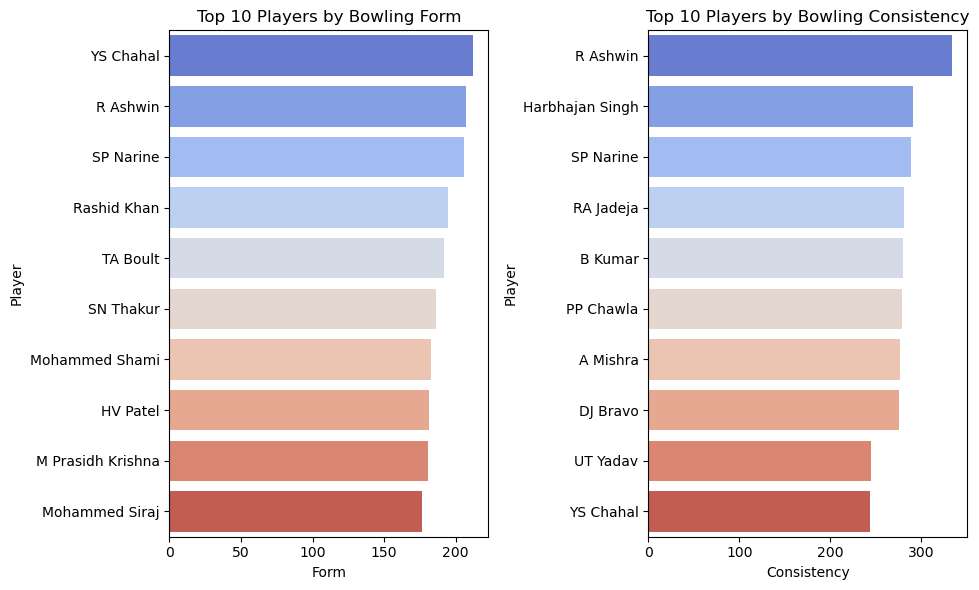

In [69]:
# Plotting Bowling Form and Consistency
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Form', y='Player', data=ipl_bowling_stats.sort_values(by='Form', ascending=False).head(10), palette='coolwarm')
plt.title('Top 10 Players by Bowling Form')

plt.subplot(1, 2, 2)
sns.barplot(x='Consistency', y='Player', data=ipl_bowling_stats.sort_values(by='Consistency', ascending=False).head(10), palette='coolwarm')
plt.title('Top 10 Players by Bowling Consistency')
plt.tight_layout()
plt.show()

## Calculating the weights for fielding metrics (using AHP)

For fielding metrics, the weighting process reflects the relative importance of each type of fielding action—catches, stumpings, and run-outs—alongside the number of innings a player has fielded in. The Analytic Hierarchy Process (AHP) is used to determine these weights. AHP helps in dealing with complex decision-making and enables the evaluation of elements by breaking them down into a series of pairwise comparisons. Here’s how the weights for fielding metrics were derived using AHP:

1. **Pairwise Comparison**: Each fielding attribute (Fielding Innings, Catches, Stumpings, Run Outs) is compared against each other to evaluate their importance in contributing to a player’s fielding ability. For example, catches might be compared with stumpings to decide which has a greater impact on a game’s outcome.

2. **Setting Priorities**: After comparing each pair of attributes, priorities are set based on the results of these comparisons. For instance, catches and run-outs might receive higher priorities because they directly prevent runs or remove batsmen from play, which are crucial for winning matches.

3. **Calculating Weights**: AHP uses the priorities to calculate a numerical weight for each attribute, reflecting its relative importance in the overall fielding performance. These weights are normalized to ensure that their sum equals 1.

4. **Assigning Scores**: For each player, AHP assigns a score to each attribute based on the player's performance data. A higher score indicates better performance in that attribute.

5. **Combining Scores**: The final step in AHP is to combine the weighted scores to produce a global score for each player, which ranks their overall fielding performance.

Reference: Saaty, T. L. (1980). The Analytic Hierarchy Process. New York: McGraw-Hill.

### Cricket Fielding Comparisons:

1. **Fielding Innings vs. Catches**:
   - **Innings**: These are the number of times you're out on the field during a cricket match. The longer you're out there, the more chances you have to make plays.
   - **Catches**: When you catch the ball to get a batsman out. Since catching is an actual skill and affects the game by getting players out, we consider it a bit more important than just being present on the field. 
   - **Scoring**: 2 points for every catch and only 0.5 points for each inning you play.

2. **Fielding Innings vs. Stumpings**:
   - **Stumpings**: Occur when a wicketkeeper uses quick reflexes to hit the stumps with the ball before the batsman can get back in the crease. Stumpings don’t happen as often as catches and require great skill and timing, so they're valued more than just participating in the innings.
   - **Scoring**: 3 points for each stumping and 0.33 points for each inning.

3. **Fielding Innings vs. Run Outs**:
   - **Run Outs**: These also change the game significantly. They involve throwing the ball to hit the stumps and get the batsman out before they can reach the safe zone. Because of their impact, we might value a run out as 3 points compared to 0.33 points for each inning, like stumpings.
   - **Scoring**: 3 points for run outs vs. 0.33 for innings.

4. **Catches vs. Stumpings**:
   - Comparing these two, stumpings are a bit tougher and less common than catches. Therefore, we give a slight edge to stumpings over catches in scoring.
   - **Scoring**: 1.5 points for stumpings and 0.67 points for catches.

5. **Catches vs. Run Outs**:
   - Run outs, like stumpings, often require more teamwork and accuracy. So, we might score run outs a bit higher than catches.
   - **Scoring**: 1.5 points for run outs vs. 0.67 points for catches.

6. **Stumpings vs. Run Outs**:
   - Both stumpings and run outs are rare and need a lot of skill. They can both dramatically change the flow of a game.
   - **Scoring**: 1 point each, indicating equal importance.

These points are like a scoring system to judge how valuable different fielding actions are in a game of cricket. More points mean the action has a bigger impact on the game's outcome.


In [14]:
# Defining the pairwise comparison matrix
matrix = np.array([
    [1,   1/2, 1/3, 1/3],  # Fielding Innings
    [2,   1,   2/3, 2/3],  # Catches
    [3,   3/2, 1,   1  ],  # Stumpings
    [3,   3/2, 1,   1  ]   # Run Outs
])

# Normalizing the matrix
column_sums = np.sum(matrix, axis=0)
normalized_matrix = matrix / column_sums

# Calculating the weights
weights = np.mean(normalized_matrix, axis=1)

# Calculating the Consistency Index (CI) and the Random Consistency Index (RI)
n = matrix.shape[0]
lambda_max = np.real(np.max(np.linalg.eig(matrix)[0]))
CI = (lambda_max - n) / (n - 1)
RI = [0, 0, 0.58, 0.90, 1.12, 1.24, 1.32, 1.41, 1.45][n-1]  # Values from a standard table for n=1 to n=9
CR = CI / RI

print("Weights:", weights)
print("Consistency Ratio (CR):", CR)
if CR < 0.1:
    print("The matrix is consistent.")
else:
    print("Review the pairwise comparisons as the matrix is not consistent.")

Weights: [0.11111111 0.22222222 0.33333333 0.33333333]
Consistency Ratio (CR): 0.0
The matrix is consistent.


## Calculating Fielding Performance Using AHP Weights

Once the Analytic Hierarchy Process (AHP) has been used to determine the weights for various fielding actions, these weights are applied to calculate a comprehensive fielding performance score for each player. This score combines the different aspects of fielding—innings fielded, catches, stumpings, and run outs—into a single metric that reflects a player's overall effectiveness in the field.

### Fielding Performance Formula
The fielding performance formula integrates the weighted contributions of different fielding actions. Here's how it's calculated:

$$
\text{Fielding Consistency} = 0.1111 \times \text{Fielding Innings} + 0.2222 \times \text{Catches} + 0.3333 \times \text{Stumpings} + 0.3333 \times \text{Run Outs}
$$

In [15]:
def calculate_fielding_consistency(row):
    weights = [0.1111, 0.2222, 0.3333, 0.3333]  
    return (
        weights[0] * row['Fielding Innings'] +
        weights[1] * row['Catches'] +
        weights[2] * row['Stumpings'] +
        weights[3] * row['Run Outs']
    )

def calculate_fielding_form(player, current_date):
    recent_matches = ipl_ball_by_ball[
        (ipl_ball_by_ball['fielders_involved'] == player) & 
        (ipl_ball_by_ball['Date'] >= (current_date - pd.DateOffset(years=1)))
    ]
    if recent_matches.empty:
        return 0

    recent_stats = {
        'Player': player,
        'Fielding Innings': recent_matches['ID'].nunique(),
        'Catches': 0,
        'Stumpings': 0,
        'Run Outs': 0
    }

    # Calculating recent catches
    recent_catches = recent_matches[recent_matches['kind'] == 'caught'].groupby('fielders_involved').size()
    if not recent_catches.empty:
        recent_stats['Catches'] = recent_catches.iloc[0]

    # Calculating recent stumpings
    recent_stumpings = recent_matches[recent_matches['kind'] == 'stumped'].groupby('fielders_involved').size()
    if not recent_stumpings.empty:
        recent_stats['Stumpings'] = recent_stumpings.iloc[0]

    # Calculating recent run outs
    recent_run_outs = recent_matches[recent_matches['kind'] == 'run out'].groupby('fielders_involved').size()
    if not recent_run_outs.empty:
        recent_stats['Run Outs'] = recent_run_outs.iloc[0]

    # Converting recent_stats to a pandas Series to pass to calculate_fielding_consistency
    recent_stats_series = pd.Series(recent_stats)

    return calculate_fielding_consistency(recent_stats_series)

# Calculating derived attributes for fielding
ipl_fielding_stats['Consistency'] = ipl_fielding_stats.apply(calculate_fielding_consistency, axis=1)
ipl_fielding_stats['Form'] = ipl_fielding_stats['Player'].apply(lambda player: calculate_fielding_form(player, current_date))

In [16]:
ipl_fielding_stats

,Player,Catches,Stumpings,Run Outs,Fielding Innings,Consistency,Form
0,A Ashish Reddy,8.0,0.0,2.0,10.0,3.5552,0.0000
1,A Badoni,8.0,0.0,1.0,9.0,3.1108,2.7775
2,A Chandila,2.0,0.0,0.0,2.0,0.6666,0.0000
3,A Chopra,2.0,0.0,1.0,3.0,1.1110,0.0000
4,A Flintoff,3.0,0.0,0.0,3.0,0.9999,0.0000
...,...,...,...,...,...,...,...
530,HE van der Dussen,0.0,0.0,1.0,1.0,0.4444,0.4444
531,Mashrafe Mortaza,0.0,0.0,1.0,1.0,0.4444,0.0000
532,Ramandeep Singh,0.0,0.0,1.0,1.0,0.4444,0.4444
533,Umar Gul,0.0,0.0,1.0,1.0,0.4444,0.0000


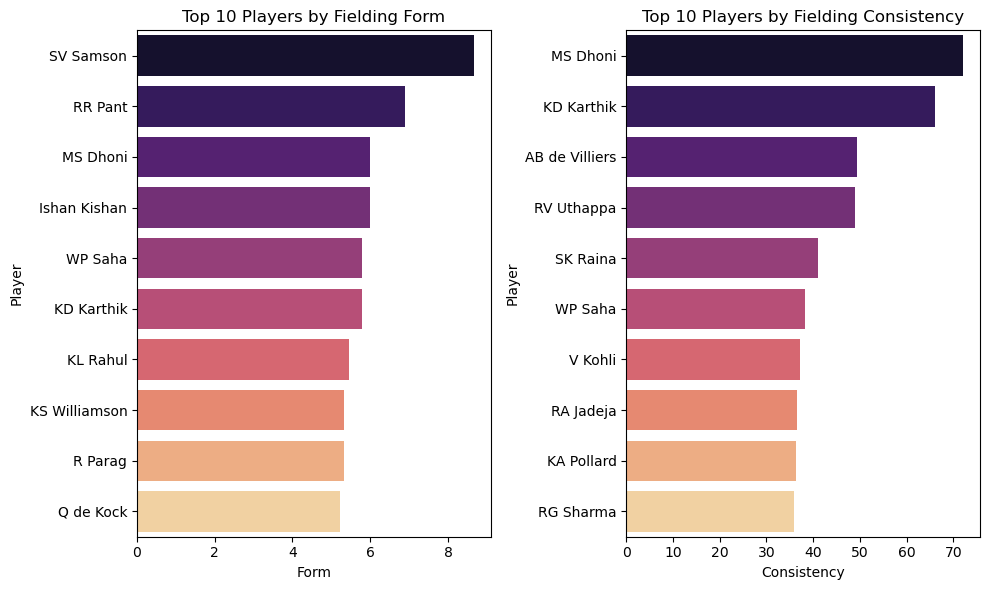

In [17]:
# Plotting Fielding Form and Consistency
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Form', y='Player', data=ipl_fielding_stats.sort_values(by='Form', ascending=False).head(10), palette='magma')
plt.title('Top 10 Players by Fielding Form')

plt.subplot(1, 2, 2)
sns.barplot(x='Consistency', y='Player', data=ipl_fielding_stats.sort_values(by='Consistency', ascending=False).head(10), palette='magma')
plt.title('Top 10 Players by Fielding Consistency')
plt.tight_layout()
plt.show()

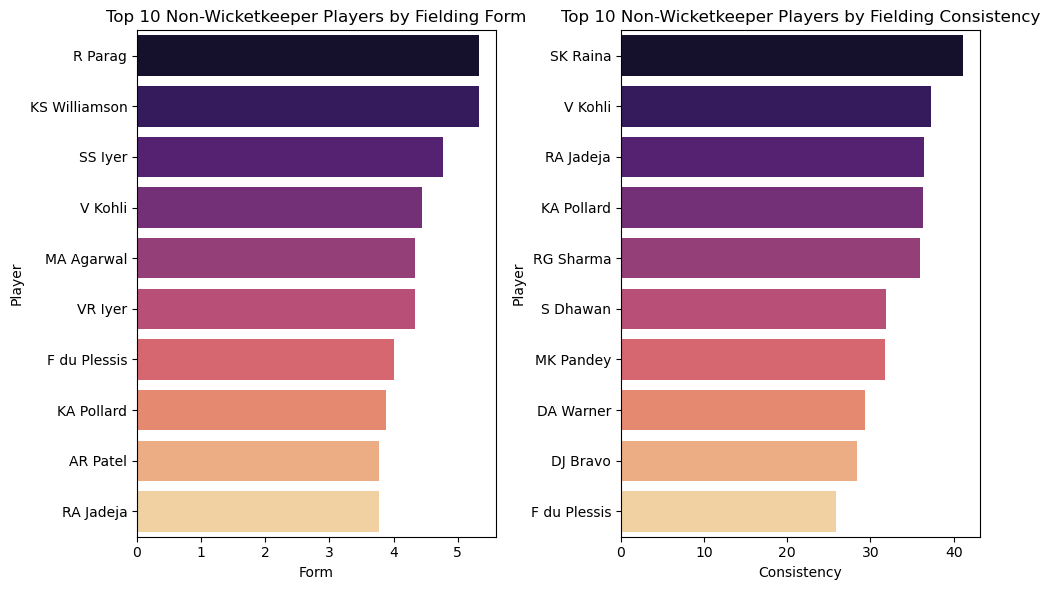

In [18]:
non_wk_fielding_stats = ipl_fielding_stats[ipl_fielding_stats['Stumpings'] == 0]

# Plotting Fielding Form and Consistency for non-wicketkeepers
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Form', y='Player', data=non_wk_fielding_stats.sort_values(by='Form', ascending=False).head(10), palette='magma')
plt.title('Top 10 Non-Wicketkeeper Players by Fielding Form')

plt.subplot(1, 2, 2)
sns.barplot(x='Consistency', y='Player', data=non_wk_fielding_stats.sort_values(by='Consistency', ascending=False).head(10), palette='magma')
plt.title('Top 10 Non-Wicketkeeper Players by Fielding Consistency')
plt.tight_layout()
plt.show()

## Manual test to see if the consistency and form scores are working

### Batting stats

In [19]:
ipl_batting_stats[ipl_batting_stats['Player'] == 'RG Sharma']

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score,Consistency,Form
430,RG Sharma,4632,4632,5881,203,28.970443,126.964594,1,40,196.0,109,1215.963957,113.425796


In [20]:
ipl_batting_stats[ipl_batting_stats['Player'] == 'V Kohli']

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score,Consistency,Form
569,V Kohli,5266,5266,6634,193,34.373057,125.977972,5,45,186.0,113,1381.722771,150.932742


In [21]:
ipl_batting_stats[ipl_batting_stats['Player'] == 'AT Rayudu']

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score,Consistency,Form
60,AT Rayudu,3375,3375,4190,142,29.507042,124.148148,1,22,138.0,100,894.122772,114.293451


### Bowling stats

In [22]:
ipl_bowling_stats[ipl_bowling_stats['Player']=='Yash Dayal']

,Player,Innings,Balls Bowled,Runs Conceded,Wickets,Overs,Bowling Average,Bowling Strike Rate,Five Wicket Haul,Consistency,Form
469,Yash Dayal,9,205,283,13,34.1,21.769231,15.769231,0.0,21.252671,75.084252


In [23]:
ipl_bowling_stats[ipl_bowling_stats['Player']=='JJ Bumrah']

,Player,Innings,Balls Bowled,Runs Conceded,Wickets,Overs,Bowling Average,Bowling Strike Rate,Five Wicket Haul,Consistency,Form
177,JJ Bumrah,120,2857,3298,161,476.1,20.484472,17.745342,2.0,235.29518,176.2018


### Fielding stats

In [24]:
ipl_fielding_stats[ipl_fielding_stats['Player']=='MS Dhoni']

,Player,Catches,Stumpings,Run Outs,Fielding Innings,Consistency,Form
296,MS Dhoni,135.0,39.0,22.0,196.0,72.1039,5.9994


In [25]:
ipl_fielding_stats[ipl_fielding_stats['Player']=='V Kohli']

,Player,Catches,Stumpings,Run Outs,Fielding Innings,Consistency,Form
500,V Kohli,93.0,0.0,14.0,107.0,37.2185,4.444


## Standardizing the player names from IPL dataset to the International Dataset

In [26]:
import pandas as pd
import re

def remove_country_info(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\s*\(.*\)', '', x))
    return df

# Removing country info from ESPN dataframes
espncricinfo_batsmen = remove_country_info(espncricinfo_batsmen, 'Player')
espncricinfo_bowlers = remove_country_info(espncricinfo_bowlers, 'Player')
espncricinfo_fielders = remove_country_info(espncricinfo_fielders, 'Player')

In [27]:
espncricinfo_batsmen.head(5)

,S.No,Player,Span,Matches Played,Innings,N/O,Runs,HIS,Batting Avg,Balls,SR,100s,50s,0,boundaries,sixes,
0,0,RG Sharma,2007-2022,124,116,15,3308,118,32.75,2365,139.87,4,26,7,292,155,NaN
1,1,MJ Guptill,2009-2021,112,108,7,3299,105,32.66,2413,136.71,2,20,3,287,165,NaN
2,2,V Kohli,2010-2022,97,89,25,3296,94*,51.50,2394,137.67,0,30,3,298,92,NaN
3,3,PR Stirling,2009-2022,102,101,8,2776,115*,29.84,2061,134.69,1,20,9,319,96,NaN
4,4,AJ Finch,2011-2022,88,88,10,2686,172,34.43,1847,145.42,2,15,7,267,113,NaN


In [28]:
ipl_batting_stats.head(5)

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score,Consistency,Form
0,A Ashish Reddy,196,196,280,15,18.666667,142.857143,0,0,14.0,36,79.361562,0.000000
1,A Badoni,139,139,161,9,17.888889,115.827338,0,1,9.0,54,60.541973,60.486373
2,A Chandila,7,7,4,1,4.000000,57.142857,0,0,1.0,4,12.096771,0.000000
3,A Chopra,75,75,53,5,10.600000,70.666667,0,0,5.0,24,34.269387,0.000000
4,A Choudhary,20,20,25,2,12.500000,125.000000,0,0,2.0,15,29.268900,0.000000


# International Attributes

In [29]:
# Calculating traditional batting attributes for international data
intl_batting_stats = espncricinfo_batsmen[['Player', 'Innings', 'Runs', 'Balls', '100s', '50s', 0]].copy()
intl_batting_stats['Dismissals'] = intl_batting_stats['Innings'] - espncricinfo_batsmen['N/O']
intl_batting_stats['Batting Average'] = intl_batting_stats['Runs'] / intl_batting_stats['Dismissals']
intl_batting_stats['Strike Rate'] = (intl_batting_stats['Runs'] / intl_batting_stats['Balls']) * 100
intl_batting_stats.rename(columns={'100s': 'Centuries', '50s': 'Fifties', 0: 'Zeros'}, inplace=True)
intl_batting_stats['Highest Score'] = espncricinfo_batsmen['HIS']

intl_batting_stats

,Player,Innings,Runs,Balls,Centuries,Fifties,Zeros,Dismissals,Batting Average,Strike Rate,Highest Score
0,RG Sharma,116,3308,2365,4,26,7,101,32.752475,139.873150,118
1,MJ Guptill,108,3299,2413,2,20,3,101,32.663366,136.717779,105
2,V Kohli,89,3296,2394,0,30,3,64,51.500000,137.677527,94*
3,PR Stirling,101,2776,2061,1,20,9,93,29.849462,134.691897,115*
4,AJ Finch,88,2686,1847,2,15,7,78,34.435897,145.425014,172
...,...,...,...,...,...,...,...,...,...,...,...
445,R Panchal,12,220,236,0,1,1,8,27.500000,93.220339,71*
446,AD Poynter,14,219,184,0,1,1,11,19.909091,119.021739,57
447,Tanwir Afzal,18,219,173,0,1,4,16,13.687500,126.589595,56
448,TT Bresnan,22,216,170,0,0,3,13,16.615385,127.058824,47*


In [30]:
# Calculating traditional bowling attributes for international data
intl_bowling_stats = espncricinfo_bowlers[['Player', 'Innings', 'Overs', 'Runs', 'Wkts', '4wkts', '5wkts']].copy()
intl_bowling_stats['Balls Bowled'] = intl_bowling_stats['Overs'] * 6
intl_bowling_stats['Bowling Average'] = intl_bowling_stats['Runs'] / intl_bowling_stats['Wkts']
intl_bowling_stats['Bowling Strike Rate'] = intl_bowling_stats['Balls Bowled'] / intl_bowling_stats['Wkts']
intl_bowling_stats['Four Wicket Haul'] = intl_bowling_stats['4wkts'] + intl_bowling_stats['5wkts']

intl_bowling_stats

,Player,Innings,Overs,Runs,Wkts,4wkts,5wkts,Balls Bowled,Bowling Average,Bowling Strike Rate,Four Wicket Haul
0,Shakib Al Hasan,93,347.3,2316,117,5,1,2083.8,19.794872,17.810256,6
1,TG Southee,90,332.5,2729,111,1,1,1995.0,24.585586,17.972973,2
2,SL Malinga,83,299.5,2225,107,1,2,1797.0,20.794393,16.794393,3
3,Rashid Khan,56,211.2,1312,103,4,2,1267.2,12.737864,12.302913,6
4,Shahid Afridi,97,361.2,2396,98,3,0,2167.2,24.448980,22.114286,3
...,...,...,...,...,...,...,...,...,...,...,...
445,DA Blignaut,13,29.4,213,11,1,0,176.4,19.363636,16.036364,1
446,S Davizi,6,14.2,124,11,1,0,85.2,11.272727,7.745455,1
447,N Dutta,11,39.0,253,11,0,0,234.0,23.000000,21.272727,0
448,GC Galanis,6,16.1,126,11,0,0,96.6,11.454545,8.781818,0


In [31]:
# Cleaning and converting MD column to numeric
espncricinfo_fielders['MD'] = pd.to_numeric(espncricinfo_fielders['MD'], errors='coerce').fillna(0)

# Calculating traditional fielding attributes for international data
intl_fielding_stats = espncricinfo_fielders[['Player', 'Innings', 'CT', 'ST', 'MD']].copy()
intl_fielding_stats.rename(columns={'CT': 'Catches', 'ST': 'Stumpings', 'MD': 'Run Outs'}, inplace=True)
intl_fielding_stats['Fielding Innings'] = intl_fielding_stats[['Catches', 'Stumpings', 'Run Outs']].sum(axis=1)

intl_fielding_stats

,Player,Innings,Catches,Stumpings,Run Outs,Fielding Innings
0,MS Dhoni,97,57,34,0.0,91.0
1,AB de Villiers,78,65,7,0.0,72.0
2,DA Miller,95,70,1,0.0,71.0
3,Mushfiqur Rahim,97,42,29,0.0,71.0
4,Q de Kock,61,49,15,0.0,64.0
...,...,...,...,...,...,...
445,BMAJ Mendis,22,7,0,0.0,7.0
446,Mohammad Saifuddin,29,7,0,0.0,7.0
447,Mohammed Nadeem,26,7,0,0.0,7.0
448,PJ Moor,21,7,0,0.0,7.0


In [32]:
# Calculating traditional batting attributes for international data
intl_batting_stats = espncricinfo_batsmen[['Player', 'Innings', 'Runs', 'Balls', '100s', '50s', 0]].copy()
intl_batting_stats['Dismissals'] = intl_batting_stats['Innings'] - espncricinfo_batsmen['N/O']
intl_batting_stats['Batting Average'] = intl_batting_stats['Runs'] / intl_batting_stats['Dismissals']
intl_batting_stats['Strike Rate'] = (intl_batting_stats['Runs'] / intl_batting_stats['Balls']) * 100
intl_batting_stats.rename(columns={'100s': 'Centuries', '50s': 'Fifties', 0: 'Zeros'}, inplace=True)
intl_batting_stats['Highest Score'] = espncricinfo_batsmen['HIS']

# Calculating derived attributes for international batting data
intl_batting_stats['Consistency'] = intl_batting_stats.apply(calculate_batting_consistency, axis=1)
intl_batting_stats['Form'] = intl_batting_stats['Player'].apply(lambda player: calculate_batting_form(player, current_date))

In [33]:
intl_batting_stats

,Player,Innings,Runs,Balls,Centuries,Fifties,Zeros,Dismissals,Batting Average,Strike Rate,Highest Score,Consistency,Form
0,RG Sharma,116,3308,2365,4,26,7,101,32.752475,139.873150,118,66.376351,113.425796
1,MJ Guptill,108,3299,2413,2,20,3,101,32.663366,136.717779,105,63.449311,0.000000
2,V Kohli,89,3296,2394,0,30,3,64,51.500000,137.677527,94*,67.145607,150.932742
3,PR Stirling,101,2776,2061,1,20,9,93,29.849462,134.691897,115*,59.872417,0.000000
4,AJ Finch,88,2686,1847,2,15,7,78,34.435897,145.425014,172,59.978357,42.425495
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,R Panchal,12,220,236,0,1,1,8,27.500000,93.220339,71*,28.898771,0.000000
446,AD Poynter,14,219,184,0,1,1,11,19.909091,119.021739,57,30.072737,0.000000
447,Tanwir Afzal,18,219,173,0,1,4,16,13.687500,126.589595,56,29.491841,0.000000
448,TT Bresnan,22,216,170,0,0,3,13,16.615385,127.058824,47*,31.814159,0.000000


In [34]:
# Calculating traditional bowling attributes for international data
intl_bowling_stats = espncricinfo_bowlers[['Player', 'Innings', 'Overs', 'Runs', 'Wkts', '5wkts']].copy()
intl_bowling_stats['Balls Bowled'] = intl_bowling_stats['Overs'] * 6
intl_bowling_stats['Bowling Average'] = intl_bowling_stats.apply(lambda row: row['Runs'] / row['Wkts'] if row['Wkts'] > 0 else 0, axis=1)
intl_bowling_stats['Bowling Strike Rate'] = intl_bowling_stats.apply(lambda row: row['Balls Bowled'] / row['Wkts'] if row['Wkts'] > 0 else 0, axis=1)
intl_bowling_stats['Five Wicket Haul'] = intl_bowling_stats['5wkts']

# Calculating derived attributes for international bowling data
intl_bowling_stats['Consistency'] = intl_bowling_stats.apply(calculate_bowling_consistency, axis=1)
intl_bowling_stats['Form'] = intl_bowling_stats['Player'].apply(lambda player: calculate_bowling_form(player, current_date))

In [35]:
intl_bowling_stats

,Player,Innings,Overs,Runs,Wkts,5wkts,Balls Bowled,Bowling Average,Bowling Strike Rate,Five Wicket Haul,Consistency,Form
0,Shakib Al Hasan,93,347.3,2316,117,1,2083.8,19.794872,17.810256,1,174.303923,43.132923
1,TG Southee,90,332.5,2729,111,1,1995.0,24.585586,17.972973,1,167.829365,104.381062
2,SL Malinga,83,299.5,2225,107,2,1797.0,20.794393,16.794393,2,151.714415,0.000000
3,Rashid Khan,56,211.2,1312,103,2,1267.2,12.737864,12.302913,2,106.241148,194.927447
4,Shahid Afridi,97,361.2,2396,98,0,2167.2,24.448980,22.114286,0,182.241164,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
445,DA Blignaut,13,29.4,213,11,0,176.4,19.363636,16.036364,0,20.152740,0.000000
446,S Davizi,6,14.2,124,11,0,85.2,11.272727,7.745455,0,9.847393,0.000000
447,N Dutta,11,39.0,253,11,0,234.0,23.000000,21.272727,0,24.826391,0.000000
448,GC Galanis,6,16.1,126,11,0,96.6,11.454545,8.781818,0,10.824205,0.000000


In [36]:
# Calculating derived attributes for international fielding data
intl_fielding_stats['Consistency'] = intl_fielding_stats.apply(calculate_fielding_consistency, axis=1)
intl_fielding_stats['Form'] = intl_fielding_stats['Player'].apply(lambda player: calculate_fielding_form(player, current_date))

In [37]:
intl_fielding_stats

,Player,Innings,Catches,Stumpings,Run Outs,Fielding Innings,Consistency,Form
0,MS Dhoni,97,57,34,0.0,91.0,34.1077,5.9994
1,AB de Villiers,78,65,7,0.0,72.0,24.7753,1.9998
2,DA Miller,95,70,1,0.0,71.0,23.7754,2.7775
3,Mushfiqur Rahim,97,42,29,0.0,71.0,26.8862,0.0000
4,Q de Kock,61,49,15,0.0,64.0,22.9977,5.2217
...,...,...,...,...,...,...,...,...
445,BMAJ Mendis,22,7,0,0.0,7.0,2.3331,0.0000
446,Mohammad Saifuddin,29,7,0,0.0,7.0,2.3331,0.0000
447,Mohammed Nadeem,26,7,0,0.0,7.0,2.3331,0.0000
448,PJ Moor,21,7,0,0.0,7.0,2.3331,0.0000


## Cleaning the dataframes before merge

In [38]:
ipl_batting_stats = ipl_batting_stats.fillna(0)
ipl_batting_stats = ipl_batting_stats.replace([float('inf'), -float('inf')], 0)
ipl_bowling_stats = ipl_bowling_stats.fillna(0)
ipl_bowling_stats = ipl_bowling_stats.replace([float('inf'), -float('inf')], 0)
ipl_fielding_stats = ipl_fielding_stats.fillna(0)
ipl_fielding_stats = ipl_fielding_stats.replace([float('inf'), -float('inf')], 0)
intl_batting_stats = intl_batting_stats.fillna(0)
intl_batting_stats = intl_batting_stats.replace([float('inf'), -float('inf')], 0)
intl_bowling_stats = intl_bowling_stats.fillna(0)
intl_bowling_stats = intl_bowling_stats.replace([float('inf'), -float('inf')], 0)
intl_fielding_stats = intl_fielding_stats.fillna(0)
intl_fielding_stats = intl_fielding_stats.replace([float('inf'), -float('inf')], 0)

## Manual test to see if the consistency and form scores are working

In [39]:
ipl_batting_stats[ipl_batting_stats['Player']=='V Kohli']

,Player,Innings,Balls Faced,Runs,Dismissals,Batting Average,Strike Rate,Centuries,Fifties,Zeros,Highest Score,Consistency,Form
569,V Kohli,5266,5266,6634,193,34.373057,125.977972,5,45,186.0,113,1381.722771,150.932742


In [40]:
intl_bowling_stats[intl_bowling_stats['Player']=='JJ Bumrah']

,Player,Innings,Overs,Runs,Wkts,5wkts,Balls Bowled,Bowling Average,Bowling Strike Rate,Five Wicket Haul,Consistency,Form
17,JJ Bumrah,56,204.5,1333,67,0,1227.0,19.895522,18.313433,0,104.982325,176.2018


In [41]:
intl_fielding_stats[intl_fielding_stats['Player']=='V Kohli']

,Player,Innings,Catches,Stumpings,Run Outs,Fielding Innings,Consistency,Form
26,V Kohli,96,43,0,0.0,43.0,14.3319,4.444


# Merging IPL and International Attributes

Assigning 75% importance to IPL (Indian Premier League) performance and 25% importance to international performance to calculate an overall score for each player.

In [42]:
ipl_players = set(ipl_batting_stats['Player']).union(set(ipl_bowling_stats['Player'])).union(set(ipl_fielding_stats['Player']))

# Combining IPL and International scores

# Merge batting stats
batting_stats_combined = ipl_batting_stats.merge(
    intl_batting_stats[['Player', 'Form', 'Consistency']], 
    on='Player', 
    suffixes=('_IPL', '_Intl'), 
    how='outer'
)
batting_stats_combined.fillna(0, inplace=True)
batting_stats_combined['Combined Form'] = 0.75 * batting_stats_combined['Form_IPL'] + 0.25 * batting_stats_combined['Form_Intl']
batting_stats_combined['Combined Consistency'] = 0.75 * batting_stats_combined['Consistency_IPL'] + 0.25 * batting_stats_combined['Consistency_Intl']

# Merging bowling stats
bowling_stats_combined = ipl_bowling_stats.merge(
    intl_bowling_stats[['Player', 'Form', 'Consistency']], 
    on='Player', 
    suffixes=('_IPL', '_Intl'), 
    how='outer'
)
bowling_stats_combined.fillna(0, inplace=True)
bowling_stats_combined['Combined Form'] = 0.75 * bowling_stats_combined['Form_IPL'] + 0.25 * bowling_stats_combined['Form_Intl']
bowling_stats_combined['Combined Consistency'] = 0.75 * bowling_stats_combined['Consistency_IPL'] + 0.25 * bowling_stats_combined['Consistency_Intl']

# Merging fielding stats
fielding_stats_combined = ipl_fielding_stats.merge(
    intl_fielding_stats[['Player', 'Form', 'Consistency']], 
    on='Player', 
    suffixes=('_IPL', '_Intl'), 
    how='outer'
)
fielding_stats_combined.fillna(0, inplace=True)
fielding_stats_combined['Combined Form'] = 0.75 * fielding_stats_combined['Form_IPL'] + 0.25 * fielding_stats_combined['Form_Intl']
fielding_stats_combined['Combined Consistency'] = 0.75 * fielding_stats_combined['Consistency_IPL'] + 0.25 * fielding_stats_combined['Consistency_Intl']

# Merging all combined stats into one dataframe
player_stats_combined = batting_stats_combined[['Player', 'Combined Form', 'Combined Consistency']].merge(
    bowling_stats_combined[['Player', 'Combined Form', 'Combined Consistency']], 
    on='Player', 
    suffixes=('_Batting', '_Bowling'), 
    how='outer'
).merge(
    fielding_stats_combined[['Player', 'Combined Form', 'Combined Consistency']], 
    on='Player', 
    suffixes=('', '_Fielding'), 
    how='outer'
).fillna(0)

# Renaming the combined fielding columns correctly
player_stats_combined.rename(columns={'Combined Form': 'Combined Form_Fielding', 'Combined Consistency': 'Combined Consistency_Fielding'}, inplace=True)

# Filtering to include only IPL players
player_stats_combined = player_stats_combined[player_stats_combined['Player'].isin(ipl_players)]

In [43]:
player_stats_combined

,Player,Combined Form_Batting,Combined Consistency_Batting,Combined Form_Bowling,Combined Consistency_Bowling,Combined Form_Fielding,Combined Consistency_Fielding
0,A Ashish Reddy,0.000000,59.521171,0.000000,21.231237,0.000000,2.666400
1,A Badoni,45.364779,45.406479,4.395525,2.144287,2.083125,2.333100
2,A Chandila,0.000000,9.072579,0.000000,18.744218,0.000000,0.499950
3,A Chopra,0.000000,25.702040,0.000000,0.000000,0.000000,0.833250
4,A Choudhary,0.000000,21.951675,0.000000,11.221515,0.000000,0.000000
...,...,...,...,...,...,...,...
955,Tejas Baroka,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1176,AV Wankhade,0.000000,0.000000,0.000000,0.000000,0.000000,0.249975
1177,B Aparajith,0.000000,0.000000,0.000000,0.000000,0.000000,0.249975
1178,Milind Kumar,0.000000,0.000000,0.000000,0.000000,0.000000,0.249975


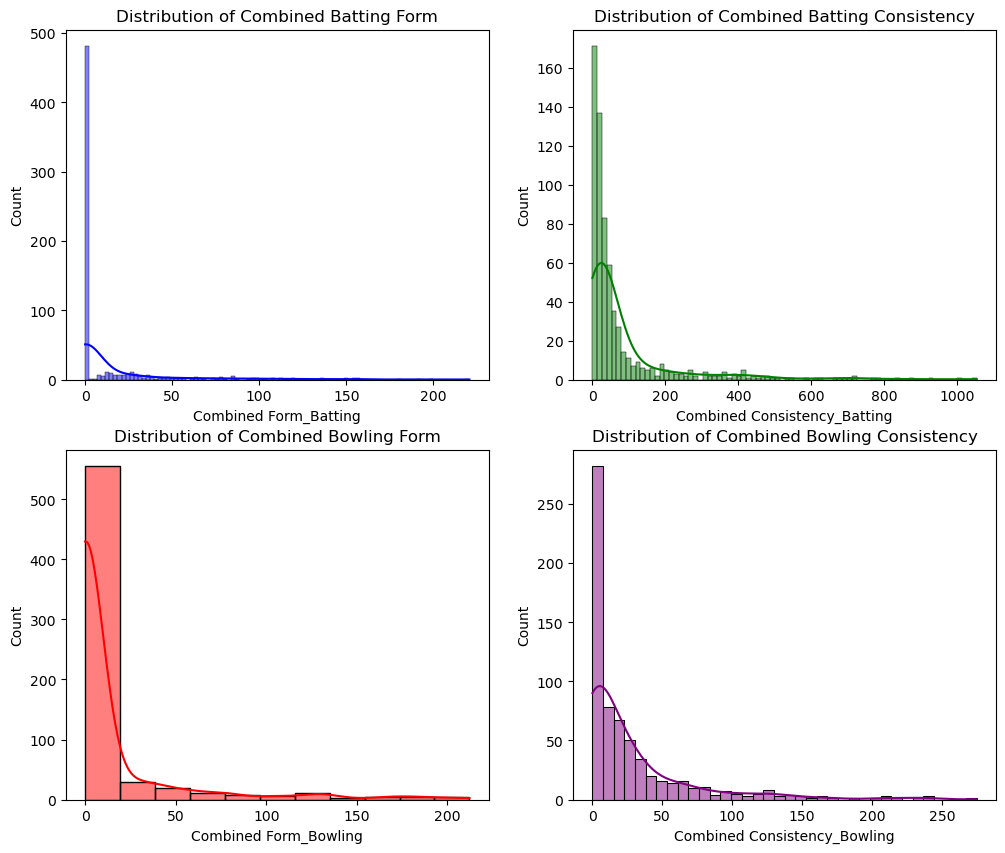

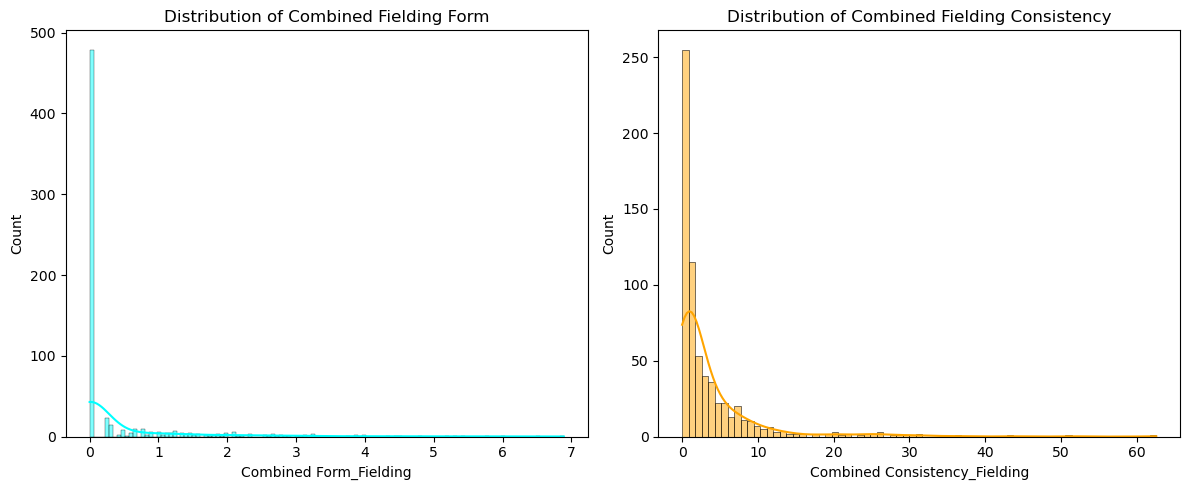

In [44]:
# Plotting histograms of combined stats
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
sns.histplot(data=player_stats_combined, x='Combined Form_Batting', kde=True, color='blue')
plt.title('Distribution of Combined Batting Form')

plt.subplot(2, 2, 2)
sns.histplot(data=player_stats_combined, x='Combined Consistency_Batting', kde=True, color='green')
plt.title('Distribution of Combined Batting Consistency')

plt.subplot(2, 2, 3)
sns.histplot(data=player_stats_combined, x='Combined Form_Bowling', kde=True, color='red')
plt.title('Distribution of Combined Bowling Form')

plt.subplot(2, 2, 4)
sns.histplot(data=player_stats_combined, x='Combined Consistency_Bowling', kde=True, color='purple')
plt.title('Distribution of Combined Bowling Consistency')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=player_stats_combined, x='Combined Form_Fielding', kde=True, color='cyan')
plt.title('Distribution of Combined Fielding Form')

plt.subplot(1, 2, 2)
sns.histplot(data=player_stats_combined, x='Combined Consistency_Fielding', kde=True, color='orange')
plt.title('Distribution of Combined Fielding Consistency')

plt.tight_layout()
plt.show()

In [45]:
player_stats_combined[player_stats_combined['Player']=='RG Sharma']

,Player,Combined Form_Batting,Combined Consistency_Batting,Combined Form_Bowling,Combined Consistency_Bowling,Combined Form_Fielding,Combined Consistency_Fielding
430,RG Sharma,113.425796,928.567055,0.237967,29.132374,2.6664,31.16355


In [46]:
player_stats_combined[player_stats_combined['Player']=='V Kohli']

,Player,Combined Form_Batting,Combined Consistency_Batting,Combined Form_Bowling,Combined Consistency_Bowling,Combined Form_Fielding,Combined Consistency_Fielding
569,V Kohli,150.932742,1053.07848,0.0,30.43167,4.444,31.49685


In [47]:
player_stats_combined[player_stats_combined['Player']=='JJ Bumrah']

,Player,Combined Form_Batting,Combined Consistency_Batting,Combined Form_Bowling,Combined Consistency_Bowling,Combined Form_Fielding,Combined Consistency_Fielding
227,JJ Bumrah,12.5127,24.478421,176.2018,202.716966,0.6666,4.3329


In [48]:
player_stats_combined[player_stats_combined['Player']=='SV Samson']

,Player,Combined Form_Batting,Combined Consistency_Batting,Combined Form_Bowling,Combined Consistency_Bowling,Combined Form_Fielding,Combined Consistency_Fielding
519,SV Samson,119.274913,534.968535,0.0,0.0,6.49935,26.247375


# Merging the combined player impact features to the IPL Matches table

In [49]:
ipl_matches

,ID,City,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2
0,1312200,Ahmedabad,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
1,1312199,Ahmedabad,2022-05-27,2022,Qualifier 2,Royal Challengers Bangalore,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,N,Rajasthan Royals,Wickets,7.0,NaN,JC Buttler,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...",CB Gaffaney,Nitin Menon
2,1312198,Kolkata,2022-05-25,2022,Eliminator,Royal Challengers Bangalore,Lucknow Super Giants,"Eden Gardens, Kolkata",Lucknow Super Giants,field,N,Royal Challengers Bangalore,Runs,14.0,NaN,RM Patidar,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['Q de Kock', 'KL Rahul', 'M Vohra', 'DJ Hooda...",J Madanagopal,MA Gough
3,1312197,Kolkata,2022-05-24,2022,Qualifier 1,Rajasthan Royals,Gujarat Titans,"Eden Gardens, Kolkata",Gujarat Titans,field,N,Gujarat Titans,Wickets,7.0,NaN,DA Miller,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",BNJ Oxenford,VK Sharma
4,1304116,Mumbai,2022-05-22,2022,70,Sunrisers Hyderabad,Punjab Kings,"Wankhede Stadium, Mumbai",Sunrisers Hyderabad,bat,N,Punjab Kings,Wickets,5.0,NaN,Harpreet Brar,"['PK Garg', 'Abhishek Sharma', 'RA Tripathi', ...","['JM Bairstow', 'S Dhawan', 'M Shahrukh Khan',...",AK Chaudhary,NA Patwardhan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,335986,Kolkata,2008-04-20,2007/08,4,Kolkata Knight Riders,Deccan Chargers,Eden Gardens,Deccan Chargers,bat,N,Kolkata Knight Riders,Wickets,5.0,NaN,DJ Hussey,"['WP Saha', 'BB McCullum', 'RT Ponting', 'SC G...","['AC Gilchrist', 'Y Venugopal Rao', 'VVS Laxma...",BF Bowden,K Hariharan
946,335985,Mumbai,2008-04-20,2007/08,5,Mumbai Indians,Royal Challengers Bangalore,Wankhede Stadium,Mumbai Indians,bat,N,Royal Challengers Bangalore,Wickets,5.0,NaN,MV Boucher,"['L Ronchi', 'ST Jayasuriya', 'DJ Thornely', '...","['S Chanderpaul', 'R Dravid', 'LRPL Taylor', '...",SJ Davis,DJ Harper
947,335984,Delhi,2008-04-19,2007/08,3,Delhi Daredevils,Rajasthan Royals,Feroz Shah Kotla,Rajasthan Royals,bat,N,Delhi Daredevils,Wickets,9.0,NaN,MF Maharoof,"['G Gambhir', 'V Sehwag', 'S Dhawan', 'MK Tiwa...","['T Kohli', 'YK Pathan', 'SR Watson', 'M Kaif'...",Aleem Dar,GA Pratapkumar
948,335983,Chandigarh,2008-04-19,2007/08,2,Kings XI Punjab,Chennai Super Kings,"Punjab Cricket Association Stadium, Mohali",Chennai Super Kings,bat,N,Chennai Super Kings,Runs,33.0,NaN,MEK Hussey,"['K Goel', 'JR Hopes', 'KC Sangakkara', 'Yuvra...","['PA Patel', 'ML Hayden', 'MEK Hussey', 'MS Dh...",MR Benson,SL Shastri


In [50]:
import pandas as pd
import re
import ast

In [51]:
# Ensuring that Team1Players and Team2Players are evaluated properly
def safe_eval(expr):
    try:
        return ast.literal_eval(expr)
    except (ValueError, SyntaxError):
        return []

# Applying safe_eval only if the column type is string
if ipl_matches['Team1Players'].dtype == 'object':
    ipl_matches['Team1Players'] = ipl_matches['Team1Players'].apply(safe_eval)
if ipl_matches['Team2Players'].dtype == 'object':
    ipl_matches['Team2Players'] = ipl_matches['Team2Players'].apply(safe_eval)

# Validating that player lists are properly converted
print("Team1Players and Team2Players after parsing:")
print(ipl_matches[['Team1Players', 'Team2Players']].head(10))

Team1Players and Team2Players after parsing:
                                        Team1Players  \
0  [YBK Jaiswal, JC Buttler, SV Samson, D Padikka...   
1  [V Kohli, F du Plessis, RM Patidar, GJ Maxwell...   
2  [V Kohli, F du Plessis, RM Patidar, GJ Maxwell...   
3  [YBK Jaiswal, JC Buttler, SV Samson, D Padikka...   
4  [PK Garg, Abhishek Sharma, RA Tripathi, AK Mar...   
5  [PP Shaw, DA Warner, MR Marsh, RR Pant, SN Kha...   
6  [RD Gaikwad, DP Conway, MM Ali, N Jagadeesan, ...   
7  [WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...   
8  [Q de Kock, KL Rahul, E Lewis, DJ Hooda, M Voh...   
9  [Abhishek Sharma, PK Garg, RA Tripathi, N Poor...   

                                        Team2Players  
0  [WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...  
1  [YBK Jaiswal, JC Buttler, SV Samson, D Padikka...  
2  [Q de Kock, KL Rahul, M Vohra, DJ Hooda, MP St...  
3  [WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...  
4  [JM Bairstow, S Dhawan, M Shahrukh Khan, MA Ag...  
5  [Isha

In [52]:
def get_team_impact_stats(players, player_stats_combined, score_type):
    return [player_stats_combined[player_stats_combined['Player'] == player][score_type].values[0] if player in player_stats_combined['Player'].values else 0 for player in players]

final_match_data = []

for idx, match in ipl_matches.iterrows():
    team1_players = match['Team1Players']
    team2_players = match['Team2Players']

    team1_batting_form = get_team_impact_stats(team1_players, player_stats_combined, 'Combined Form_Batting')
    team1_batting_consistency = get_team_impact_stats(team1_players, player_stats_combined, 'Combined Consistency_Batting')
    team1_bowling_form = get_team_impact_stats(team1_players, player_stats_combined, 'Combined Form_Bowling')
    team1_bowling_consistency = get_team_impact_stats(team1_players, player_stats_combined, 'Combined Consistency_Bowling')
    team1_fielding_form = get_team_impact_stats(team1_players, player_stats_combined, 'Combined Form_Fielding')
    team1_fielding_consistency = get_team_impact_stats(team1_players, player_stats_combined, 'Combined Consistency_Fielding')

    team2_batting_form = get_team_impact_stats(team2_players, player_stats_combined, 'Combined Form_Batting')
    team2_batting_consistency = get_team_impact_stats(team2_players, player_stats_combined, 'Combined Consistency_Batting')
    team2_bowling_form = get_team_impact_stats(team2_players, player_stats_combined, 'Combined Form_Bowling')
    team2_bowling_consistency = get_team_impact_stats(team2_players, player_stats_combined, 'Combined Consistency_Bowling')
    team2_fielding_form = get_team_impact_stats(team2_players, player_stats_combined, 'Combined Form_Fielding')
    team2_fielding_consistency = get_team_impact_stats(team2_players, player_stats_combined, 'Combined Consistency_Fielding')

    match_data = {
        'ID': match['ID'],
        'Venue': match['Venue'],
        'Team1': match['Team1'],
        'Team1Players': team1_players,
        'Team2': match['Team2'],
        'Team2Players': team2_players,
        'Team1_Batting_Form': team1_batting_form,
        'Team1_Batting_Consistency': team1_batting_consistency,
        'Team1_Bowling_Form': team1_bowling_form,
        'Team1_Bowling_Consistency': team1_bowling_consistency,
        'Team1_Fielding_Form': team1_fielding_form,
        'Team1_Fielding_Consistency': team1_fielding_consistency,
        'Team2_Batting_Form': team2_batting_form,
        'Team2_Batting_Consistency': team2_batting_consistency,
        'Team2_Bowling_Form': team2_bowling_form,
        'Team2_Bowling_Consistency': team2_bowling_consistency,
        'Team2_Fielding_Form': team2_fielding_form,
        'Team2_Fielding_Consistency': team2_fielding_consistency,
        'WinningTeam': match['WinningTeam'],
        'WonBy': match['WonBy'],
        'Margin': match['Margin'],
        'Player_of_Match': match['Player_of_Match']
    }
    
    final_match_data.append(match_data)

# Creating a new dataframe
final_match_df = pd.DataFrame(final_match_data)

In [53]:
final_match_df

,ID,Venue,Team1,Team1Players,Team2,Team2Players,Team1_Batting_Form,Team1_Batting_Consistency,Team1_Bowling_Form,Team1_Bowling_Consistency,...,Team2_Batting_Form,Team2_Batting_Consistency,Team2_Bowling_Form,Team2_Bowling_Consistency,Team2_Fielding_Form,Team2_Fielding_Consistency,WinningTeam,WonBy,Margin,Player_of_Match
0,1312200,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,"[YBK Jaiswal, JC Buttler, SV Samson, D Padikka...",Gujarat Titans,"[WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...","[84.49292300819062, 198.85970398210287, 119.27...","[101.17511818663837, 418.976772197593, 534.968...","[0.2379675, 0.0, 0.0, 0.0, 0.0, 207.2992052631...","[0.0, 0.0, 0.0, 0.0, 0.0, 274.8539937351611, 2...",...,"[97.05431487341772, 153.99359666272187, 60.696...","[395.84447115501666, 322.59738413810015, 60.25...","[0.0, 0.0, 0.0, 71.7227825, 0.0, 42.3042642857...","[0.0, 0.0, 0.0, 94.93906054582212, 0.0, 59.355...","[4.3329, 2.583075, 2.8886000000000003, 2.5553,...","[28.747124999999997, 7.49925, 6.027175, 17.164...",Gujarat Titans,Wickets,7.0,HH Pandya
1,1312199,"Narendra Modi Stadium, Ahmedabad",Royal Challengers Bangalore,"[V Kohli, F du Plessis, RM Patidar, GJ Maxwell...",Rajasthan Royals,"[YBK Jaiswal, JC Buttler, SV Samson, D Padikka...","[150.9327424366872, 191.51208671794873, 78.496...","[1053.0784796354806, 551.5431144103063, 85.372...","[0.0, 0.0, 0.0, 85.85427727272727, 27.5214675,...","[30.431670000000004, 0.0, 0.0, 78.842554482922...",...,"[84.49292300819062, 198.85970398210287, 119.27...","[101.17511818663837, 418.976772197593, 534.968...","[0.2379675, 0.0, 0.0, 0.0, 0.0, 19.97660250000...","[0.0, 0.0, 0.0, 0.0, 0.0, 20.10591, 274.853993...","[0.9999000000000001, 2.7775, 6.499350000000001...","[1.4998500000000001, 15.442900000000002, 26.24...",Rajasthan Royals,Wickets,7.0,JC Buttler
2,1312198,"Eden Gardens, Kolkata",Royal Challengers Bangalore,"[V Kohli, F du Plessis, RM Patidar, GJ Maxwell...",Lucknow Super Giants,"[Q de Kock, KL Rahul, M Vohra, DJ Hooda, MP St...","[150.9327424366872, 191.51208671794873, 78.496...","[1053.0784796354806, 551.5431144103063, 85.372...","[0.0, 0.0, 0.0, 85.85427727272727, 27.5214675,...","[30.431670000000004, 0.0, 0.0, 78.842554482922...",...,"[156.17021991614257, 220.7323393115942, 26.289...","[443.3248796483526, 607.0587822950193, 184.545...","[0.0, 0.0, 0.0, 21.483150000000002, 16.6442212...","[0.0, 0.0, 0.0, 32.4421725, 49.491711428571435...","[5.2217, 5.4439, 0.0, 2.3331, 1.33320000000000...","[27.663899999999998, 19.525825, 3.582975000000...",Royal Challengers Bangalore,Runs,14.0,RM Patidar
3,1312197,"Eden Gardens, Kolkata",Rajasthan Royals,"[YBK Jaiswal, JC Buttler, SV Samson, D Padikka...",Gujarat Titans,"[WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...","[84.49292300819062, 198.85970398210287, 119.27...","[101.17511818663837, 418.976772197593, 534.968...","[0.2379675, 0.0, 0.0, 0.0, 0.0, 19.97660250000...","[0.0, 0.0, 0.0, 0.0, 0.0, 20.10591, 274.853993...",...,"[97.05431487341772, 153.99359666272187, 60.696...","[395.84447115501666, 322.59738413810015, 60.25...","[0.0, 0.0, 0.0, 71.7227825, 0.0, 42.3042642857...","[0.0, 0.0, 0.0, 94.93906054582212, 0.0, 59.355...","[4.3329, 2.583075, 2.8886000000000003, 2.5553,...","[28.747124999999997, 7.49925, 6.027175, 17.164...",Gujarat Titans,Wickets,7.0,DA Miller
4,1304116,"Wankhede Stadium, Mumbai",Sunrisers Hyderabad,"[PK Garg, Abhishek Sharma, RA Tripathi, AK Mar...",Punjab Kings,"[JM Bairstow, S Dhawan, M Shahrukh Khan, MA Ag...","[38.37439682539683, 99.22606140350877, 107.361...","[60.4860763392857, 119.87083855185911, 275.861...","[0.0, 18.525705000000002, 0.0, 31.888492500000...","[0.0, 16.590482142857145, 0.0, 17.965004999999...",...,"[76.88648888888889, 180.65823164383562, 47.380...","[217.62018659248238, 1013.1246947523047, 64.69...","[0.0, 0.0, 0.0, 0.0, 57.28546666666667, 0.0, 0...","[0.0, 6.38112375, 0.0, 0.0, 21.31725625, 0.0, ...","[1.4443000000000001, 3.4440999999999997, 0.916...","[10.776700000000002, 25.49745, 1.749825, 1

## Flattening the List Columns

In [54]:
import numpy as np

# Expanding the list columns into separate columns
def expand_list_column(df, column_prefix, column_name):
    max_players = df[column_name].apply(len).max()
    for i in range(max_players):
        df[f'{column_prefix}_{i+1}'] = df[column_name].apply(lambda x: x[i] if i < len(x) else 0)
    return df

# Applying to all relevant columns
final_match_df = expand_list_column(final_match_df, 'Team1_Batting_Form', 'Team1_Batting_Form')
final_match_df = expand_list_column(final_match_df, 'Team1_Batting_Consistency', 'Team1_Batting_Consistency')
final_match_df = expand_list_column(final_match_df, 'Team1_Bowling_Form', 'Team1_Bowling_Form')
final_match_df = expand_list_column(final_match_df, 'Team1_Bowling_Consistency', 'Team1_Bowling_Consistency')
final_match_df = expand_list_column(final_match_df, 'Team1_Fielding_Form', 'Team1_Fielding_Form')
final_match_df = expand_list_column(final_match_df, 'Team1_Fielding_Consistency', 'Team1_Fielding_Consistency')
final_match_df = expand_list_column(final_match_df, 'Team2_Batting_Form', 'Team2_Batting_Form')
final_match_df = expand_list_column(final_match_df, 'Team2_Batting_Consistency', 'Team2_Batting_Consistency')
final_match_df = expand_list_column(final_match_df, 'Team2_Bowling_Form', 'Team2_Bowling_Form')
final_match_df = expand_list_column(final_match_df, 'Team2_Bowling_Consistency', 'Team2_Bowling_Consistency')
final_match_df = expand_list_column(final_match_df, 'Team2_Fielding_Form', 'Team2_Fielding_Form')
final_match_df = expand_list_column(final_match_df, 'Team2_Fielding_Consistency', 'Team2_Fielding_Consistency')

# Dropping the original list columns
final_match_df.drop(columns=[
    'Team1_Batting_Form', 'Team1_Batting_Consistency', 'Team1_Bowling_Form', 'Team1_Bowling_Consistency', 'Team1_Fielding_Form', 'Team1_Fielding_Consistency',
    'Team2_Batting_Form', 'Team2_Batting_Consistency', 'Team2_Bowling_Form', 'Team2_Bowling_Consistency', 'Team2_Fielding_Form', 'Team2_Fielding_Consistency'
], inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6348\2048831000.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column_prefix}_{i+1}'] = df[column_name].apply(lambda x: x[i] if i < len(x) else 0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6348\2048831000.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column_prefix}_{i+1}'] = df[column_name].apply(lambda x: x[i] if i < len(x) else 0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6348\2048831000.py:7: PerformanceWarning: DataFrame is highly 

## Additional Feature Engineering

In [55]:
from sklearn.preprocessing import LabelEncoder

# Standardizing team names
team_name_mapping = {
    "Delhi Daredevils": "Delhi Capitals",
    "Punjab Kings": "Kings XI Punjab",
    "Rising Pune Supergiants": "Rising Pune Supergiant",
    "Deccan Chargers": "Sunrisers Hyderabad", 
    "Gujarat Lions": "Gujarat Titans",
    "Pune Warriors": "Rising Pune Supergiant" 
}

# Applying name mapping
final_match_df['WinningTeam'] = final_match_df['WinningTeam'].replace(team_name_mapping)
final_match_df['Team1'] = final_match_df['Team1'].replace(team_name_mapping)
final_match_df['Team2'] = final_match_df['Team2'].replace(team_name_mapping)

# Creating a binary target: 1 if Team1 won, 0 otherwise
final_match_df['Team1_Win'] = (final_match_df['WinningTeam'] == final_match_df['Team1']).astype(int)

# One-hot encode Team1, Team2, Venue, and WonBy columns, excluding the first category to avoid multicollinearity
final_match_df = pd.get_dummies(final_match_df, columns=['Venue', 'WonBy'], drop_first=True)
final_match_df = pd.get_dummies(final_match_df, columns=['Team1', 'Team2'])

# Dropping the original WinningTeam column as it's no longer needed after encoding
final_match_df.drop(['WinningTeam'], axis=1, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6348\4267139758.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_match_df['Team1_Win'] = (final_match_df['WinningTeam'] == final_match_df['Team1']).astype(int)


In [56]:
final_match_df.columns.tolist()

['ID',
 'Team1Players',
 'Team2Players',
 'Margin',
 'Player_of_Match',
 'Team1_Batting_Form_1',
 'Team1_Batting_Form_2',
 'Team1_Batting_Form_3',
 'Team1_Batting_Form_4',
 'Team1_Batting_Form_5',
 'Team1_Batting_Form_6',
 'Team1_Batting_Form_7',
 'Team1_Batting_Form_8',
 'Team1_Batting_Form_9',
 'Team1_Batting_Form_10',
 'Team1_Batting_Form_11',
 'Team1_Batting_Consistency_1',
 'Team1_Batting_Consistency_2',
 'Team1_Batting_Consistency_3',
 'Team1_Batting_Consistency_4',
 'Team1_Batting_Consistency_5',
 'Team1_Batting_Consistency_6',
 'Team1_Batting_Consistency_7',
 'Team1_Batting_Consistency_8',
 'Team1_Batting_Consistency_9',
 'Team1_Batting_Consistency_10',
 'Team1_Batting_Consistency_11',
 'Team1_Bowling_Form_1',
 'Team1_Bowling_Form_2',
 'Team1_Bowling_Form_3',
 'Team1_Bowling_Form_4',
 'Team1_Bowling_Form_5',
 'Team1_Bowling_Form_6',
 'Team1_Bowling_Form_7',
 'Team1_Bowling_Form_8',
 'Team1_Bowling_Form_9',
 'Team1_Bowling_Form_10',
 'Team1_Bowling_Form_11',
 'Team1_Bowling_Cons

In [57]:
# To avoid dummy variable trap
del final_match_df['Team1_Rising Pune Supergiant']
del final_match_df['Team2_Rising Pune Supergiant']

## Summarizing the Features: Identifying Top Performers in Batting, Bowling, and Fielding

### Importance of Identifying Top Performers
In competitive sports like cricket, understanding who the top performers are in various aspects of the game is crucial. By focusing on batting, bowling, and fielding - both in terms of form and consistency - we can pinpoint which players are likely to have the most significant impact in matches. This analysis helps in strategic planning, player selection, and performance optimization, ensuring that teams are as competitive as possible.

### Methodology for Summarizing Features
The process involves identifying the top four players in each aspect (batting, bowling, fielding) based on their performance metrics. The analysis not only highlights those who are currently in good form but also those who consistently perform well, providing a balanced view of player capabilities.

### Steps in the Process
1. **Feature Extraction**: For each team and each match, performance metrics are extracted for batting, bowling, and fielding. These metrics include form and consistency scores calculated through previously established methods.
2. **Ranking and Selection**: The players are ranked based on these metrics, and the top four performers in each category are identified. This is done to ensure that the focus is on players who excel, making substantial contributions to their teams.
3. **Dataframe Transformation**: We use a Python function to transform the original DataFrame, extracting and ranking the top performers for each metric. This involves:
   - Filtering columns based on specific prefixes that denote different performance aspects.
   - Applying numeric operations to ensure that all data used for ranking is in the correct format.
   - Calculating the top performers for each category and each team using a customized function that handles ranking based on provided metrics.

In [58]:
def create_top_performers_features(df, column_prefix, num_top_performers=4):
    cols = [col for col in df.columns if col.startswith(column_prefix)]
    
    # Ensure columns are numeric
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    top_performers_df = pd.DataFrame(index=df.index)
    
    # Get top performers for each row
    for i in range(1, num_top_performers + 1):
        top_performers_df[f'{column_prefix}_Top{i}'] = df[cols].apply(
            lambda row: row.nlargest(i).values[-1] if len(row.nlargest(i)) >= i else 0, axis=1)
    
    return top_performers_df

def create_top_performers_only(df):
    summary_columns = [
        'Team1_Batting_Form', 'Team1_Batting_Consistency', 'Team1_Bowling_Form',
        'Team1_Bowling_Consistency', 'Team1_Fielding_Form', 'Team1_Fielding_Consistency',
        'Team2_Batting_Form', 'Team2_Batting_Consistency', 'Team2_Bowling_Form',
        'Team2_Bowling_Consistency', 'Team2_Fielding_Form', 'Team2_Fielding_Consistency'
    ]
    
    all_top_performers = []
    
    for column_prefix in summary_columns:
        top_performers_df = create_top_performers_features(df, column_prefix, num_top_performers=4)
        all_top_performers.append(top_performers_df)
        
        # Dropping the original columns to avoid redundancy
        df.drop(columns=[col for col in df.columns if col.startswith(column_prefix)], inplace=True)
    
    # Concatenating all top performers dataframes
    top_performers_combined_df = pd.concat(all_top_performers, axis=1)
    
    # Concatenating back to the original dataframe
    df = pd.concat([df, top_performers_combined_df], axis=1)
    
    return df

# Applying the function to your DataFrame
final_match_df = create_top_performers_only(final_match_df)

In [59]:
final_match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Columns: 127 entries, ID to Team2_Fielding_Consistency_Top4
dtypes: bool(73), float64(49), int32(1), int64(1), object(3)
memory usage: 464.9+ KB


In [60]:
final_match_df

,ID,Team1Players,Team2Players,Margin,Player_of_Match,Team1_Win,"Venue_Arun Jaitley Stadium, Delhi",Venue_Barabati Stadium,Venue_Brabourne Stadium,"Venue_Brabourne Stadium, Mumbai",...,Team2_Bowling_Consistency_Top3,Team2_Bowling_Consistency_Top4,Team2_Fielding_Form_Top1,Team2_Fielding_Form_Top2,Team2_Fielding_Form_Top3,Team2_Fielding_Form_Top4,Team2_Fielding_Consistency_Top1,Team2_Fielding_Consistency_Top2,Team2_Fielding_Consistency_Top3,Team2_Fielding_Consistency_Top4
0,1312200,"[YBK Jaiswal, JC Buttler, SV Samson, D Padikka...","[WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...",7.0,HH Pandya,0,False,False,False,False,...,94.939061,60.222355,4.33290,2.888600,2.777500,2.583075,28.747125,23.608750,17.164950,8.832450
1,1312199,"[V Kohli, F du Plessis, RM Patidar, GJ Maxwell...","[YBK Jaiswal, JC Buttler, SV Samson, D Padikka...",7.0,JC Buttler,0,False,False,False,False,...,137.809261,79.259101,6.49935,3.999600,2.777500,2.666400,26.247375,15.442900,10.748925,8.332500
2,1312198,"[V Kohli, F du Plessis, RM Patidar, GJ Maxwell...","[Q de Kock, KL Rahul, M Vohra, DJ Hooda, MP St...",14.0,RM Patidar,1,False,False,False,False,...,56.367844,49.491711,5.44390,5.221700,3.221900,2.333100,27.663900,19.525825,11.498850,8.499150
3,1312197,"[YBK Jaiswal, JC Buttler, SV Samson, D Padikka...","[WP Saha, Shubman Gill, MS Wade, HH Pandya, DA...",7.0,DA Miller,0,False,False,False,False,...,94.939061,59.355712,4.33290,2.888600,2.777500,2.583075,28.747125,23.608750,17.164950,8.832450
4,1304116,"[PK Garg, Abhishek Sharma, RA Tripathi, AK Mar...","[JM Bairstow, S Dhawan, M Shahrukh Khan, MA Ag...",5.0,Harpreet Brar,0,False,False,False,False,...,25.266285,21.317256,3.44410,3.249675,3.083025,2.666400,25.497450,13.415325,10.776700,6.915975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,335986,"[WP Saha, BB McCullum, RT Ponting, SC Ganguly,...","[AC Gilchrist, Y Venugopal Rao, VVS Laxman, A ...",5.0,DJ Hussey,1,False,False,False,False,...,39.007565,29.132374,2.66640,0.000000,0.000000,0.000000,31.163550,22.164450,9.082425,5.332800
946,335985,"[L Ronchi, ST Jayasuriya, DJ Thornely, RV Utha...","[S Chanderpaul, R Dravid, LRPL Taylor, JH Kall...",5.0,MV Boucher,0,False,False,False,False,...,138.356407,124.105902,4.44400,0.000000,0.000000,0.000000,31.496850,10.332300,9.082425,8.665800
947,335984,"[G Gambhir, V Sehwag, S Dhawan, MK Tiwary, KD ...","[T Kohli, YK Pathan, SR Watson, M Kaif, DS Leh...",9.0,MF Maharoof,1,False,False,False,False,...,100.395917,91.349997,3.77740,0.000000,0.000000,0.000000,29.163750,13.998600,13.165350,5.666100
948,335983,"[K Goel, JR Hopes, KC Sangakkara, Yuvraj Singh...","[PA Patel, ML Hayden, MEK Hussey, MS Dhoni, SK...",33.0,MEK Hussey,0,False,False,False,False,...,62.126667,33.363089,5.99940,1.333200,0.000000,0.000000,62.604850,34.329900,25.914075,8.499150


## Calculating the frequency of each player being the player of the match in IPL 

In [61]:
# Calculating the frequency of each player being the player of the match
pom_frequency_series = final_match_df['Player_of_Match'].value_counts()

# Converting the Series to DataFrame
pom_frequency_df = pom_frequency_series.reset_index()
pom_frequency_df.columns = ['Player_of_Match', 'Frequency']

# Adding the frequency as a feature
final_match_df['POM_Frequency'] = final_match_df['Player_of_Match'].map(pom_frequency_series.to_dict())

# Dropping the original Player_of_Match column if no longer needed
final_match_df.drop(columns=['Player_of_Match'], inplace=True)

In [62]:
final_match_df.columns.tolist()

['ID',
 'Team1Players',
 'Team2Players',
 'Margin',
 'Team1_Win',
 'Venue_Arun Jaitley Stadium, Delhi',
 'Venue_Barabati Stadium',
 'Venue_Brabourne Stadium',
 'Venue_Brabourne Stadium, Mumbai',
 'Venue_Buffalo Park',
 'Venue_De Beers Diamond Oval',
 'Venue_Dr DY Patil Sports Academy',
 'Venue_Dr DY Patil Sports Academy, Mumbai',
 'Venue_Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
 'Venue_Dubai International Cricket Stadium',
 'Venue_Eden Gardens',
 'Venue_Eden Gardens, Kolkata',
 'Venue_Feroz Shah Kotla',
 'Venue_Green Park',
 'Venue_Himachal Pradesh Cricket Association Stadium',
 'Venue_Holkar Cricket Stadium',
 'Venue_JSCA International Stadium Complex',
 'Venue_Kingsmead',
 'Venue_M Chinnaswamy Stadium',
 'Venue_M.Chinnaswamy Stadium',
 'Venue_MA Chidambaram Stadium',
 'Venue_MA Chidambaram Stadium, Chepauk',
 'Venue_MA Chidambaram Stadium, Chepauk, Chennai',
 'Venue_Maharashtra Cricket Association Stadium',
 'Venue_Maharashtra Cricket Association Stadium, Pune',
 'Venue_

## Removing the irrelavant columns to make the dataset model ready

In [63]:
final_match_df.drop(columns=[
    'ID', 'Team1Players', 'Team2Players'
], inplace=True)

In [64]:
final_match_df

,Margin,Team1_Win,"Venue_Arun Jaitley Stadium, Delhi",Venue_Barabati Stadium,Venue_Brabourne Stadium,"Venue_Brabourne Stadium, Mumbai",Venue_Buffalo Park,Venue_De Beers Diamond Oval,Venue_Dr DY Patil Sports Academy,"Venue_Dr DY Patil Sports Academy, Mumbai",...,Team2_Bowling_Consistency_Top4,Team2_Fielding_Form_Top1,Team2_Fielding_Form_Top2,Team2_Fielding_Form_Top3,Team2_Fielding_Form_Top4,Team2_Fielding_Consistency_Top1,Team2_Fielding_Consistency_Top2,Team2_Fielding_Consistency_Top3,Team2_Fielding_Consistency_Top4,POM_Frequency
0,7.0,0,False,False,False,False,False,False,False,False,...,60.222355,4.33290,2.888600,2.777500,2.583075,28.747125,23.608750,17.164950,8.832450,8.0
1,7.0,0,False,False,False,False,False,False,False,False,...,79.259101,6.49935,3.999600,2.777500,2.666400,26.247375,15.442900,10.748925,8.332500,10.0
2,14.0,1,False,False,False,False,False,False,False,False,...,49.491711,5.44390,5.221700,3.221900,2.333100,27.663900,19.525825,11.498850,8.499150,1.0
3,7.0,0,False,False,False,False,False,False,False,False,...,59.355712,4.33290,2.888600,2.777500,2.583075,28.747125,23.608750,17.164950,8.832450,5.0
4,5.0,0,False,False,False,False,False,False,False,False,...,21.317256,3.44410,3.249675,3.083025,2.666400,25.497450,13.415325,10.776700,6.915975,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,5.0,1,False,False,False,False,False,False,False,False,...,29.132374,2.66640,0.000000,0.000000,0.000000,31.163550,22.164450,9.082425,5.332800,2.0
946,5.0,0,False,False,False,False,False,False,False,False,...,124.105902,4.44400,0.000000,0.000000,0.000000,31.496850,10.332300,9.082425,8.665800,2.0
947,9.0,1,False,False,False,False,False,False,False,False,...,91.349997,3.77740,0.000000,0.000000,0.000000,29.163750,13.998600,13.165350,5.666100,1.0
948,33.0,0,False,False,False,False,False,False,False,False,...,33.363089,5.99940,1.333200,0.000000,0.000000,62.604850,34.329900,25.914075,8.499150,12.0


In [65]:
pkl_filename = 'FormattedData.pkl'
final_match_df.to_pickle(pkl_filename)

In [66]:
pkl_filename = 'Player_Scores.pkl'
player_stats_combined.to_pickle(pkl_filename)

In [67]:
pkl_filename = 'pom_frequency.pkl'
pom_frequency_df.to_pickle(pkl_filename)

### Reference

The methodologies used for calculating derived attributes such as Form and Consistency are based on the research presented in the following study:

- Passi, K., & Pandey, N. (2018). Increased Prediction Accuracy in the Game of Cricket Using Machine Learning. *International Journal of Data Mining & Knowledge Management Process*, 8(2). DOI: 10.5121/ijdkp.2018.8203.

- Saaty, T. L. (1980). The Analytic Hierarchy Process. New York: McGraw-Hill.